In [7]:
from Bio import SeqIO
import pandas as pd
from Bio.Seq import Seq

reverse_complement = lambda x: str(Seq(x.seq).reverse_complement())

sequence_file = "data/opJS.amplicon.long.fa"

In [10]:
with open(sequence_file) as fasta_file:
    identifiers = []
    seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):
        identifiers.append(seq_record.id)
        seq_ = reverse_complement(seq_record) # ! we reverse complement for this experiment
        seqs.append(str(seq_))

#converting lists to pandas Series    
s1 = pd.Series(identifiers, name='fragment')
s2 = pd.Series(seqs, name='seq')
#Gathering Series into a pandas DataFrame and rename index as ID column
seq_df = pd.DataFrame(dict(ID=s1, seq=s2)).set_index(['ID'])

print(f"seq_df shape {seq_df.shape}")
seq_df.head()

seq_df shape (15, 1)


,seq
ID,
opJS2_1xTetO,ATGTGTGAGTTTTGTCGGATCCGAGACGACCGCCTGATCCGCCCGT...
opJS2_2xTetO,ATGTGTGAGTTTTGTCGGATCCGAGACGACCGCCTGATCCGCCCGT...
opJS2_3xTetO,ATGTGTGAGTTTTGTCGGATCCGAGACGACCGCCTGATCCGCCCGT...
opJS2_4xTetO,ATGTGTGAGTTTTGTCGGATCCGAGACGACCGCCTGATCCGCCCGT...
opJS2_5xTetO,ATGTGTGAGTTTTGTCGGATCCGAGACGACCGCCTGATCCGCCCGT...


In [11]:
#conditions
name_c = lambda group,dox,mtase,constr: f"{group}.opJS2-{dox}{mtase}_LONG.opJSC2_{constr}.full_unclustered.matrix"
group_c = ["L057","L058","L059","L060"]
dox_c = ["24hr-1000ngDox","no-dox"]
mtase_c = ["","-plusCpG",]
construct_c = [f"{i}xTetO" for i in range (1,8)]

# MTase- , EDA

In [14]:
def compute_similarity(seq_1, seq_2):
    """
    Computes the percent similarity between two sequences ignoring gaps. 
    
    Parameters
    ----------
    seq_1, seq_2 : strings
        DNA sequences to compare. These must be the same length.
        
    Returns
    -------
    score : float
        The percent similarity between the two sequences. 
    """
    # Make sure they are the same length. 
    if len(seq_1) != len(seq_2):
        raise ValueError('Sequences must be the same length!')
        
    # Make both sequences lowercase.
    seq_1 = seq_1.lower()
    seq_2 = seq_2.lower()
        
    # Set up counters of length and similarity.
    comp_length = 0
    num_sim = 0
    
    # Iterate through each position in the sequences.
    for base in range(len(seq_1)):
        
        # Ensure we are not comparing gaps.
        if (seq_1[base] != '-') and (seq_2[base] != '-'):
            
            # Increase the counter for compared length.
            comp_length += 1
            
            # Compare the two positions.
            if seq_1[base] == seq_2[base]:
                
                # Increase the similarity counter.
                num_sim += 1
                
    # Compute and return the percent similarity.
    score = num_sim  / comp_length
    return score

count_motif = lambda motif,sequence: sequence.lower().count(motif)

In [12]:
mtase_neg_files = [name_c(g,d,"",c) for g in group_c for d in dox_c for c in construct_c]

In [46]:
from collections import Counter,defaultdict

content_count = defaultdict(dict)

for i,row in seq_df.iterrows():
    content_count[i]['gc'] = count_motif('gc',row.seq)
    content_count[i]['cg'] = count_motif('cg',row.seq)

In [65]:
content_df = pd.DataFrame.from_dict(content_count).T
content_df

,gc,cg
opJS2_1xTetO,53,31
opJS2_2xTetO,53,28
opJS2_3xTetO,48,23
opJS2_4xTetO,45,22
opJS2_5xTetO,42,22
opJS2_6xTetO,43,20
opJS2_7xTetO,44,24
opJS2_7xTetO-compact,43,21
opJS2_6xTetO-compact,45,21
opJS2_5xTetO-compact,46,23


gc    699
cg    355
dtype: int64


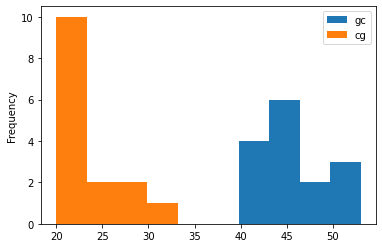

In [60]:
content_df.plot.hist()
print(content_df.sum())

<AxesSubplot:title={'center':'GC content per sequence'}, ylabel='Density'>

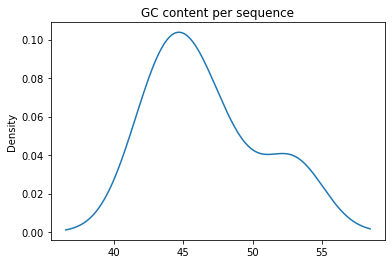

In [63]:
content_df["gc"].plot.kde(title="GC content per sequence",xlabel="# of GC pairs",ylabel="Sequence density")

<AxesSubplot:title={'center':'CG content per sequence'}, ylabel='Density'>

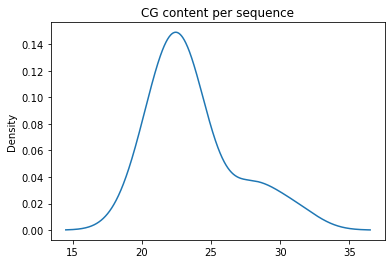

In [64]:
content_df["cg"].plot.kde(title="CG content per sequence",xlabel="# of CG pairs",ylabel="Sequence density")

It seems like we have a higher GC content in general (~1.8x higher). GC distribution seems to be bimodal - most sequences have ~45 GC islands or around ~53 GC islands. 

CG content is less bimodal - most sequences have around 20-25 CpG islands.


Given that distributions differ so much, one challenge is to account for unbalanced abundance of GC and CGs relative to each other.